In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import pandas as pd

/tmp/ipykernel_9438/2817862154.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
def parse_algo_for_sorting(algo):
    """Parse the algorithm name to extract the type and the communication frequency for sorting."""
    parts = algo.split('_')
    type_ = parts[0]  # modular or monolithic
    freq = int(''.join(filter(str.isdigit, parts[-1])))  # Extracts digits from the last part
    return type_, freq

def custom_sort(algos):
    """Sort algorithms first by type (modular/monolithic) and then by frequency."""
    algos_with_keys = [(algo, *parse_algo_for_sorting(algo)) for algo in algos]
    # Sort by type then by frequency
    sorted_algos_with_keys = sorted(algos_with_keys, key=lambda x: (x[1], x[2]))
    return [x[0] for x in sorted_algos_with_keys]
color_map = {
    'modular_comm_freq_5': '#9ecae1',  # Lighter blue
    'modular_comm_freq_10': '#6baed6',
    'modular_comm_freq_20': '#4292c6',
    'modular_comm_freq_50': '#2171b5',
    'modular_comm_freq_100': '#084594',  # Darker blue
    'monolithic_comm_freq_5': '#fcbba1',  # Lighter red
    'monolithic_comm_freq_10': '#fc9272',
    'monolithic_comm_freq_20': '#fb6a4a',
    'monolithic_comm_freq_50': '#ef3b2c',
    'monolithic_comm_freq_100': '#cb181d'   # Darker red
}


In [3]:

def postprocess_df(series, exclude_keys=None):
    """
    Takes a pandas Series with a MultiIndex and folds over all keys except for those specified
    in `exclude_keys` by concatenating the key name and its value into the 'algo' column values.

    Parameters:
    - series: pandas.Series with a MultiIndex.
    - exclude_keys: list of strings representing keys to exclude from the folding process.

    Returns:
    - A DataFrame with 'algo' and 'dataset' columns, where 'algo' has been modified to include
      information from other keys.
    """

    if exclude_keys is None:
      exclude_keys=['algo', 'dataset', 'final_acc', 'use_contrastive']
    # Convert the Series into a DataFrame
    df = series.reset_index()
    
    # # Initialize a column to store the modified algo values
    df['modified_algo'] = df['algo']
    exclude_keys += ['modified_algo']
    
    # # Iterate over each level of the original MultiIndex (now columns in df)
    for key in df.columns:
        if key not in exclude_keys:
            # Append the key name and its value to the 'modified_algo' entries
            df['modified_algo'] = df['modified_algo'] + '_' + key + ':' + df[key].astype(str)
    
    # # Select and rename the relevant columns for the final DataFrame
    final_df = df[['modified_algo', 'dataset', series.name]].copy()
    final_df.rename(columns={'modified_algo': 'algo', series.name: 'value'}, inplace=True)
    
    return final_df

def aggregate_results(df, keys=None, metric=None, post_process=True):
   if keys is None:
      keys = ["algo", "use_contrastive"]
   if metric is None:
      metric = "final_acc"
   keys += ["dataset"]
   m = df.groupby(keys)[
         metric].mean()
   stderr = df.groupby(keys)[metric].sem()
   if post_process:
      exclude_keys=["algo", "dataset", metric, 'use_contrastive']
      m = postprocess_df(m, exclude_keys)
      stderr = postprocess_df(stderr, exclude_keys)
   return m, stderr

                  
   
                   
def plot_bar_res(df, color_map=None, edgecolor_map=None, bar_width=0.2, keys=None,
      metric=None,
      remap_name=None,
      hatch_map=None,):
    """
    Corrected plotting function that properly handles DataFrame structures.
    """
    m, stderr = aggregate_results(df, keys=keys, metric=metric)

    # Extract unique datasets and algorithms for plotting
    datasets = sorted(m['dataset'].unique())[::-1]
    algos = sorted(m['algo'].unique())[::-1]
   #  algos = custom_sort(m['algo'].unique())

    # Set figure size and plot properties
    fig, ax = plt.subplots(figsize=(20, 4))
    opacity = 0.8
    linewidth = 2


    print(m)
    for i, algo in enumerate(algos):
        positions = np.arange(len(datasets)) + i * bar_width
        # Filter rows for the current algorithm
        algo_means = m[m['algo'] == algo].set_index('dataset')['value'].reindex(datasets).values
        algo_stderr = stderr[stderr['algo'] == algo].set_index('dataset')['value'].reindex(datasets).values

        ax.bar(positions, algo_means, bar_width, yerr=algo_stderr, alpha=opacity, label=remap_name[algo] if remap_name is not None else algo,
               linewidth=linewidth,
               color=color_map[algo] if color_map is not None else None, edgecolor=edgecolor_map[algo] if edgecolor_map is not None else None,
               hatch=hatch_map[algo] if hatch_map is not None else None)

    # Set x-axis labels, titles, and legend
    ax.set_xticks(np.arange(len(datasets)) + bar_width * (len(algos) - 1) / 2)
    ax.set_xticklabels(datasets, fontsize=12)
    ax.set_ylim([0.5, 1])
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel('Dataset', fontsize=14)
    ax.set_title('Comparison of Algorithm Performance', fontsize=16, fontweight='bold')
    ax.legend(frameon=True, loc='lower right', bbox_to_anchor=(1.28, 0.0))
    ax.grid(True, which='major', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig("Figures/results.pdf", bbox_inches="tight")


In [4]:
from prettytable import PrettyTable


# Prepare the PrettyTable

def make_table(pivot_m):
    table = PrettyTable()
    columns = ['Base', 'Algorithm'] + [col for col in pivot_m.columns if col not in ('base', 'algorithm')]
    table.field_names = columns

    max_values = pivot_m.max()


    for _, row in pivot_m.iterrows():
        row_data = []
        for col in pivot_m.columns:
            if col not in ('base', 'algorithm') and not pd.isna(row[col]):
                # Bold the highest value for each dataset
                if row[col] == max_values[col]:
                    row_data.append(f"**{row[col]:.5f}**")
                else:
                    row_data.append(f"{row[col]:.5f}")
            else:
                row_data.append(row[col])
        table.add_row(row_data)
    return table


def format_df_for_table(m):
    res = m.copy()
    # Remove the "_use_contrastive:False" part for cleaner extraction
    res['algo_clean'] = res['algo'].str.replace('_use_contrastive:False', '')

    # Now, extract 'base' and 'algorithm' accurately
    res['base'] = res['algo_clean'].str.extract(r'^([^_]+)')[0]
    res['algorithm'] = res['algo_clean'].str.extract(r'_(.+)$')[0]

    # Fill NaN in 'algorithm' with 'vanilla'
    res['algorithm'].fillna('vanilla', inplace=True)

    # Drop the columns we don't need anymore
    res.drop(['algo', 'algo_clean'], axis=1, inplace=True)

    res = res.pivot_table(index=['base', 'algorithm'], columns='dataset', values='value', aggfunc='first').reset_index()
    return res

                                                 algo       dataset     value
0    modular_mem_size_100_comm_freq_16_num_queries_20      cifar100  0.610280
1    modular_mem_size_100_comm_freq_16_num_queries_20  fashionmnist  0.938691
2    modular_mem_size_100_comm_freq_16_num_queries_20        kmnist  0.830819
3    modular_mem_size_100_comm_freq_16_num_queries_20         mnist  0.948369
4     modular_mem_size_100_comm_freq_9_num_queries_10      cifar100  0.608984
..                                                ...           ...       ...
67  monolithic_mem_size_32_comm_freq_50_num_querie...         mnist  0.925178
68  monolithic_mem_size_50_comm_freq_16_num_querie...      cifar100  0.504048
69  monolithic_mem_size_50_comm_freq_16_num_querie...  fashionmnist  0.917038
70  monolithic_mem_size_50_comm_freq_16_num_querie...        kmnist  0.796004
71  monolithic_mem_size_50_comm_freq_16_num_querie...         mnist  0.921146

[72 rows x 3 columns]


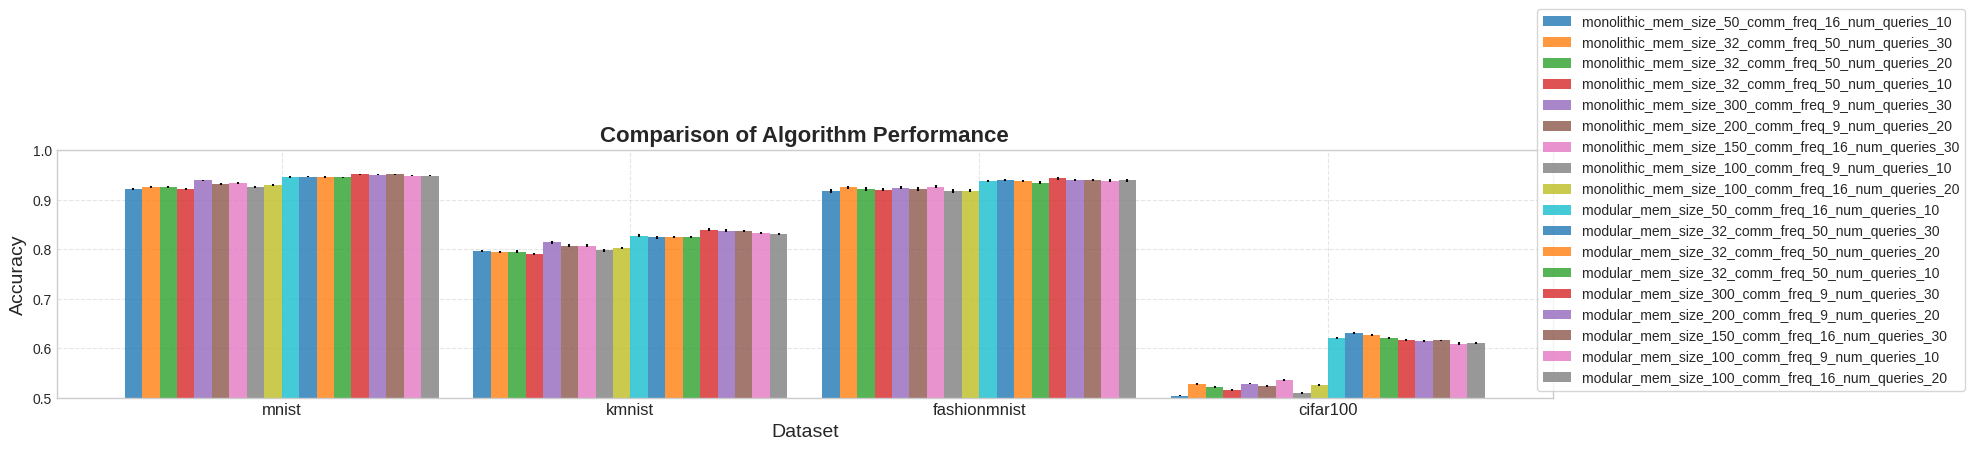

In [5]:
# df = pd.read_csv('budget_experiment_results/jorge_setting_fedavg.csv')
df = pd.read_csv('budget_experiment_results/jorge_setting_recv_variable_shared_memory_size.csv')
# df = pd.read_csv('budget_experiment_results/latest_main_no_init_tasks_no_backward_replay_jorge_setting_recv_variable_shared_memory_size.csv')
plot_bar_res(df, bar_width=0.05)

In [6]:
m , stderr = aggregate_results(df)

In [7]:
pivot_m = format_df_for_table(m)
table = make_table(pivot_m)
print(table)

+------------+------------------------------------------+-------------+--------------+-------------+-------------+
|    Base    |                Algorithm                 |   cifar100  | fashionmnist |    kmnist   |    mnist    |
+------------+------------------------------------------+-------------+--------------+-------------+-------------+
|  modular   | mem_size_100_comm_freq_16_num_queries_20 |   0.61028   |   0.93869    |   0.83082   |   0.94837   |
|  modular   | mem_size_100_comm_freq_9_num_queries_10  |   0.60898   |   0.93775    |   0.83212   |   0.94827   |
|  modular   | mem_size_150_comm_freq_16_num_queries_30 |   0.61550   |   0.93961    |   0.83608   |   0.95097   |
|  modular   | mem_size_200_comm_freq_9_num_queries_20  |   0.61488   |   0.93932    |   0.83758   |   0.95064   |
|  modular   | mem_size_300_comm_freq_9_num_queries_30  |   0.61570   | **0.94290**  | **0.83937** | **0.95130** |
|  modular   | mem_size_32_comm_freq_50_num_queries_10  |   0.61965   |   0.9343